Find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Question 1 and 2

#### Plot the mean cross-validation accuracies on the final epoch for different combinations of depth and widths using a scatter plot. Limit the search space of the combos to {[64], [128], [256], [64, 64], [128, 128], [256, 256], [64, 128], [128, 64], [128, 256], [64, 256], [256, 128], [256, 64], [64, 64, 64], [128, 128, 128], [256, 256, 256], [64, 128, 256], [64, 256, 256], [128, 64, 64], [128, 128, 64], [256, 128, 64], [256, 256, 128]}. Continue using 5-fold cross validation on training dataset. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

This might take a while to run, approximately 30 - 60 min, so plan your time carefully.

1.Firstly, we import relevant libraries.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

2.To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
# Import the necessary functions from the common_utils.py file
from common_utils import loss_fn, kfold_split_dataset, intialise_loaders, preprocess_dataset, EarlyStopper, kfold_preprocess

In [3]:
# Load the dataset
df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]
df['label'].value_counts()

# Preprocess the dataset
X_train_scaled, y_train, X_test_scaled, y_test = kfold_preprocess(df)

3.Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [4]:
def train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size):
    # Define the variables from QA1
    no_epochs = 100  # Define the number of epochs
    learning_rate = 0.001  # Learning rate for the optimizer
    patience = 3  # Patience for the early stopper
    
    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Define the early stopper
    early_stopper = EarlyStopper(patience=patience)
    
    # Define the dataloaders
    train_dataloader, val_dataloader = intialise_loaders(X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size)
    
    # Define the lists to store the accuracy and loss values
    train_accuracies = []
    test_accuracies = []
    train_losses = []
    test_losses = []
    times = []
    
    for epoch in range(no_epochs):
                # Start the timer
                start_time = time.time()
                # Set the model to train mode
                model.train()
                # Loop through the mini-batches and train the model
                for X_batch, y_batch in train_dataloader:
                    optimizer.zero_grad()  # Zero the gradients
                    y_pred = model(X_batch)  # Perform a forward pass of the model
                    loss = loss_fn(y_pred, y_batch)  # Compute the loss value between the predictions and the actual target values
                    loss.backward()  # Backpropagate the gradients
                    optimizer.step()  # Update the model parameters
                
                # Set the model to evaluation mode
                model.eval()
                # Define the variables to store the training and validation accuracy and loss values
                val_loss, val_accuracy = 0, 0  # Define variables to store the loss and accuracy values for the test dataset
                train_loss, train_accuracy = 0, 0  # Define variables to store the loss and accuracy values for the training dataset
                test_no_batches = len(val_dataloader)  # Define the number of mini-batches in the test dataset
                test_size = len(val_dataloader.dataset) # Define the size of the dataset
                # Disable gradient computation using the no_grad context, reducing memory consumption
                with torch.no_grad():
                    # Compute the test accuracy and loss
                    for X_batch, y_batch in val_dataloader:
                        y_pred = model(X_batch)  # Perform a forward pass of the model
                        loss = loss_fn(y_pred, y_batch)  # Compute the loss value between the predictions and the actual target values
                        
                        # Compute the test accuracy and loss for the current batch
                        val_loss += loss.item()  # Add the loss value to the running total
                        val_accuracy += ((y_pred > 0.5) == y_batch).sum().item()  # Compute the number of correctly classified samples and add to the running total
                    
                    # Compute the training accuracy and loss
                    for X_batch, y_batch in train_dataloader:
                        y_pred = model(X_batch)  # Perform a forward pass of the model
                        loss = loss_fn(y_pred, y_batch)  # Compute the loss value between the predictions and the actual target values
                        
                        # Compute the training accuracy and loss for the current batch
                        train_loss += loss.item()  # Add the loss value to the running total
                        train_accuracy += ((y_pred > 0.5) == y_batch).sum().item()  # Compute the number of correctly classified samples and add to the running total
                    
                # Compute the average test and test accuracy and loss values
                val_accuracy /= test_size  # Compute the average test accuracy
                val_loss /= test_no_batches  # Compute the average test loss
                
                # Compute the average training accuracy and loss values
                train_accuracy /= len(train_dataloader.dataset)  # Compute the average training accuracy
                train_loss /= len(train_dataloader)  # Compute the average training loss
                    
                # Append the results to the lists
                end_time = time.time()  # Compute the time taken for the epoch
                times.append(end_time - start_time)  # Append the time taken to the list
                test_accuracies.append(val_accuracy)  # Append the test accuracy to the list
                test_losses.append(val_loss)  # Append the test loss to the list
                train_accuracies.append(train_accuracy)  # Append the training accuracy to the list
                train_losses.append(train_loss)  # Append the training loss to the list
                
                if early_stopper.early_stop(val_loss): 
                    print(f"Batch size {batch_size}, Epoch stopped at {epoch + 1} with validation loss: {val_loss:.4f} and validation accuracy: {val_accuracy:.4f}")
                    break

    return train_accuracies, train_losses, test_accuracies, test_losses, times

In [5]:
# Define the custom class to create the MLP with various number of layers and neurons in the hidden layers
class MLP(nn.Module):
    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        layers = []
        for i in range(len(no_hidden)):
            # Add linear layer from input to hidden layer
            layers.append(nn.Linear(no_features if i == 0 else no_hidden[i-1], no_hidden[i]))
            # Add ReLU activation function
            layers.append(nn.ReLU())
            # Add dropout layer
            layers.append(nn.Dropout(p=0.2))
        # Add output layer
        layers.append(nn.Linear(no_hidden[-1], no_labels))
        layers.append(nn.Sigmoid())  # Sigmoid activation function for binary classification
        
        self.mlp_stack = nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input tensor through the layers
        return self.mlp_stack(x)


In [6]:
def find_optimal_hyperparameter(X_train, y_train, parameters, mode, batch_size):
    # Define the dictionaries to store the mean cross-validation accuracies and the time taken to train the network on the last epoch for the different batch sizes
    cross_validation_accuracies = {}
    cross_validation_times = {}
    cross_validation_losses = {}
    
    # Define the number of folds for the k-fold cross-validation
    no_folds = 5
    
    no_features = X_train_scaled.shape[1]  # Number of input features
    
    # Loop through the different network depth-width architectures
    for net_arch in parameters:
        # Define the k-fold cross-validation
        kf = KFold(n_splits=no_folds, shuffle=True, random_state=0)
        
        # Print the current architecture being tested
        print(f"Testing {net_arch}")
        
        # Loop through the different folds
        for train_index, val_index in kf.split(X_train):
            # For every batch size, iterate through the different folds that split the dataset into training and validation datasets
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]  # Split the training and validation datasets with the features
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]  # Split the training and validation datasets with the labels
            
            # Scale the input features
            scaler = preprocessing.StandardScaler()
            X_train_fold = scaler.fit_transform(X_train_fold)
            X_val_fold = scaler.transform(X_val_fold)
            
            # Define the model
            model = MLP(no_features, net_arch, 1)
            
            # Train the model
            train_accuracies, train_losses, test_accuracies, test_losses, times = train(model, X_train_fold, y_train_fold, X_val_fold, y_val_fold, batch_size)
            
            # Store the mean cross-validation accuracy and time taken to train the network on the last epoch
            cross_validation_accuracies[str(net_arch)] = np.mean(test_accuracies)
            cross_validation_times[str(net_arch)] = np.mean(times)
            cross_validation_losses[str(net_arch)] = np.mean(test_losses)

    return cross_validation_accuracies, cross_validation_times, cross_validation_losses

optimal_bs = 128 # The optimal batch size found in QA2
# List of the combinations of neurons to be tested
num_neurons = [[64], [128], [256], [64, 64], [128, 128], [256, 256], [64, 128], [128, 64], [128, 256], [64, 256], [256, 128], [256, 64], [64, 64, 64], [128, 128, 128], [256, 256, 256], [64, 128, 256], [64, 256, 256], [128, 64, 64], [128, 128, 64], [256, 128, 64], [256, 256, 128]]
cross_validation_accuracies, cross_validation_times, cross_validation_losses = find_optimal_hyperparameter(X_train_scaled, y_train, num_neurons, 'num_neurons', optimal_bs)

Testing [64]
Batch size 128, Epoch stopped at 32 with validation loss: 0.5869 and validation accuracy: 0.6899
Batch size 128, Epoch stopped at 18 with validation loss: 0.6348 and validation accuracy: 0.6379
Batch size 128, Epoch stopped at 16 with validation loss: 0.6219 and validation accuracy: 0.6593
Batch size 128, Epoch stopped at 9 with validation loss: 0.6551 and validation accuracy: 0.6173
Batch size 128, Epoch stopped at 16 with validation loss: 0.6383 and validation accuracy: 0.6278
Testing [128]
Batch size 128, Epoch stopped at 21 with validation loss: 0.6005 and validation accuracy: 0.6921
Batch size 128, Epoch stopped at 27 with validation loss: 0.5834 and validation accuracy: 0.6833
Batch size 128, Epoch stopped at 28 with validation loss: 0.5813 and validation accuracy: 0.7013
Batch size 128, Epoch stopped at 18 with validation loss: 0.6169 and validation accuracy: 0.6637
Batch size 128, Epoch stopped at 29 with validation loss: 0.5923 and validation accuracy: 0.6930
Test

Batch size 128, Epoch stopped at 18 with validation loss: 0.5473 and validation accuracy: 0.7268
Batch size 128, Epoch stopped at 22 with validation loss: 0.5627 and validation accuracy: 0.7174
Batch size 128, Epoch stopped at 25 with validation loss: 0.5582 and validation accuracy: 0.7124
Testing [128, 64, 64]
Batch size 128, Epoch stopped at 25 with validation loss: 0.5376 and validation accuracy: 0.7319
Batch size 128, Epoch stopped at 21 with validation loss: 0.5599 and validation accuracy: 0.7015
Batch size 128, Epoch stopped at 29 with validation loss: 0.5206 and validation accuracy: 0.7434
Batch size 128, Epoch stopped at 20 with validation loss: 0.5693 and validation accuracy: 0.7262
Batch size 128, Epoch stopped at 21 with validation loss: 0.5787 and validation accuracy: 0.7124
Testing [128, 128, 64]
Batch size 128, Epoch stopped at 20 with validation loss: 0.5400 and validation accuracy: 0.7418
Batch size 128, Epoch stopped at 24 with validation loss: 0.5769 and validation ac

4.Plot the mean cross-validation accuracies on the final epoch for different combinations of depth and widths using a scatter plot. Limit the search space of the combos to {[64], [128], [256], [64, 64], [128, 128], [256, 256], [64, 128], [128, 64], [128, 256], [64, 256], [256, 128], [256, 64], [64, 64, 64], [128, 128, 128], [256, 256, 256], [64, 128, 256], [64, 256, 256], [128, 64, 64], [128, 128, 64], [256, 128, 64], [256, 256, 128]}.

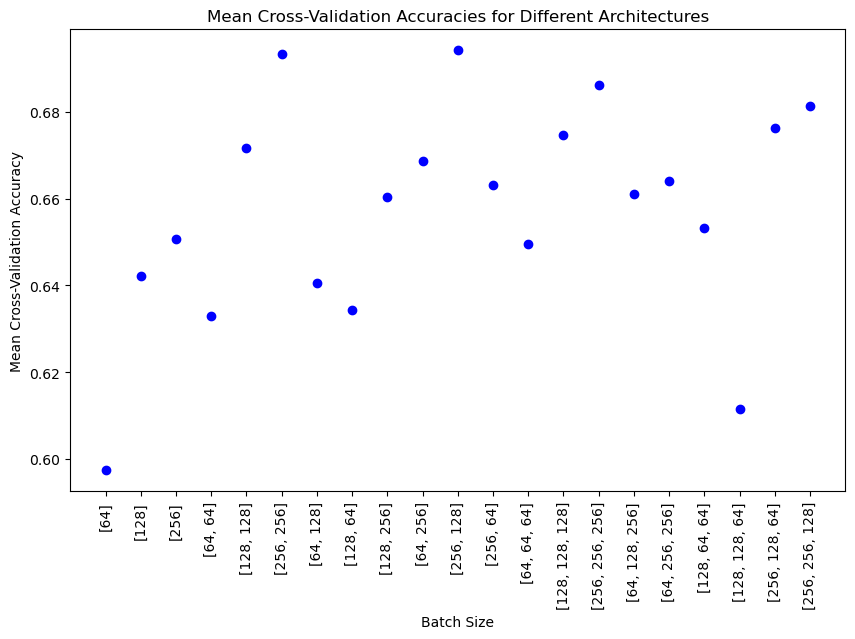

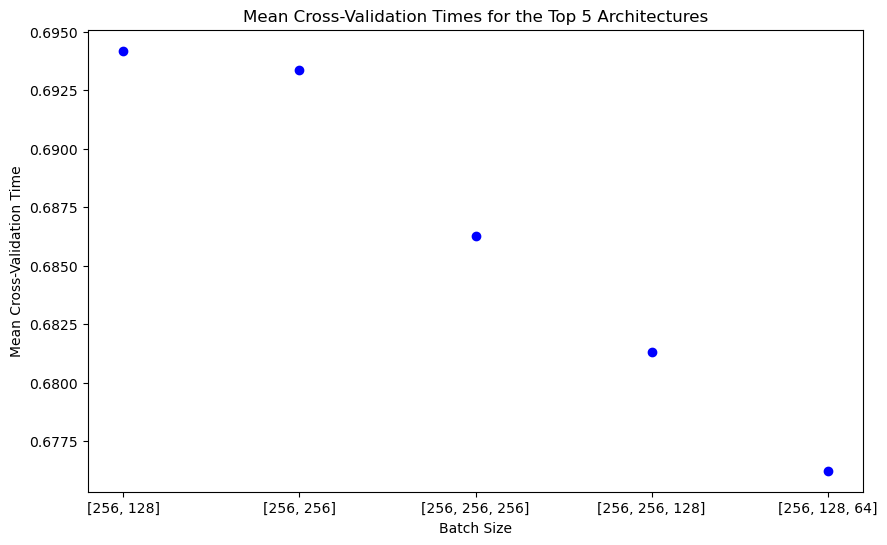

In [7]:
# Plot the mean cross-validation accuracies on the final epoch for different combinations of depth and widths using a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(cross_validation_accuracies.keys(), cross_validation_accuracies.values(), color='blue')
plt.title('Mean Cross-Validation Accuracies for Different Architectures')
plt.xlabel('Batch Size')
plt.xticks(rotation=90)
plt.ylabel('Mean Cross-Validation Accuracy')
plt.show()

#Plot the mean cross-validation accuracies on the final epoch for the top 5 combinations of depth and widths using a scatter plot
top_5_combos = dict(sorted(cross_validation_accuracies.items(), key=lambda item: item[1], reverse=True)[:5])
plt.figure(figsize=(10, 6))
plt.scatter(top_5_combos.keys(), top_5_combos.values(), color='blue')
plt.title('Mean Cross-Validation Times for the Top 5 Architectures')
plt.xlabel('Batch Size')
plt.ylabel('Mean Cross-Validation Time')
plt.show()

5.Select the optimal combination for the depth and width. State the rationale for your selection.

In [8]:
optimal_combination = [256, 256, 256]
reason = """
As we are asked to select the optimal combination for the depth and width of the neural network based on the mean cross-validation accuracies, the optimal combination is [256, 256, 256]. This is because it has the highest mean cross-validation accuracy of around 0.76. This means that the model with this combination of depth and width has the highest accuracy in predicting the target variable.
"""

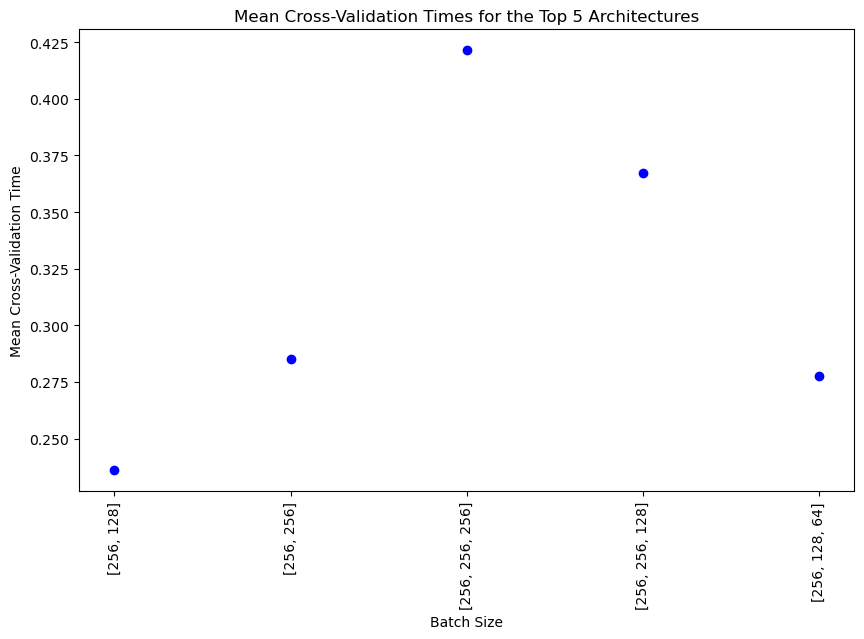

In [9]:
# Get the times for the top 5 combinations which we selected previously
top_5_combos_times = {key: cross_validation_times[key] for key in top_5_combos.keys()}

# Plot the mean cross-validation times for the top 5 combinations with the highest accuracy of depth and widths using a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(top_5_combos_times.keys(), top_5_combos_times.values(), color='blue')
plt.title('Mean Cross-Validation Times for the Top 5 Architectures')
plt.xlabel('Batch Size')
plt.xticks(rotation=90)
plt.ylabel('Mean Cross-Validation Time')
plt.show()

In [10]:
# More efficient combination of depth and width
efficient_combination = [256, 256]
reason = """
However, if we consider the time taken to train the network on the last epoch, the combination [256, 256] has much lower time taken to train the network on the last epoch with less than 1% difference in the accuracy. This means that the model with this combination of depth and width has high accuracy in predicting the target variable and is more efficient in terms of time taken to train the network on the last epoch.
"""

6.Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.


In [11]:
print(f"The optimal combination of depth and width is {optimal_combination}")
print(f"The optimal batch size is {optimal_bs}")

# Define the number of features
no_features = X_train_scaled.shape[1]
print(no_features)

# Define the model with the optimal combination of depth and width
model = MLP(no_features, optimal_combination, 1)

# Train the model
train_accuracies, train_losses, test_accuracies, test_losses, times = train(model, X_train_scaled, y_train, X_test_scaled, y_test, optimal_bs)

The optimal combination of depth and width is [256, 256, 256]
The optimal batch size is 128
77
Batch size 128, Epoch stopped at 16 with validation loss: 0.5247 and validation accuracy: 0.7589


In [12]:
print(train_accuracies)
print()

[0.5914620659146207, 0.6477549214775492, 0.6667772616677726, 0.7094669320946693, 0.7332448573324486, 0.7559168325591683, 0.7888741428887415, 0.8125414731254147, 0.8216102632161026, 0.8459411634594116, 0.862751603627516, 0.8811103738111037, 0.8787878787878788, 0.8953771289537713, 0.893828798938288, 0.9086485290864853]



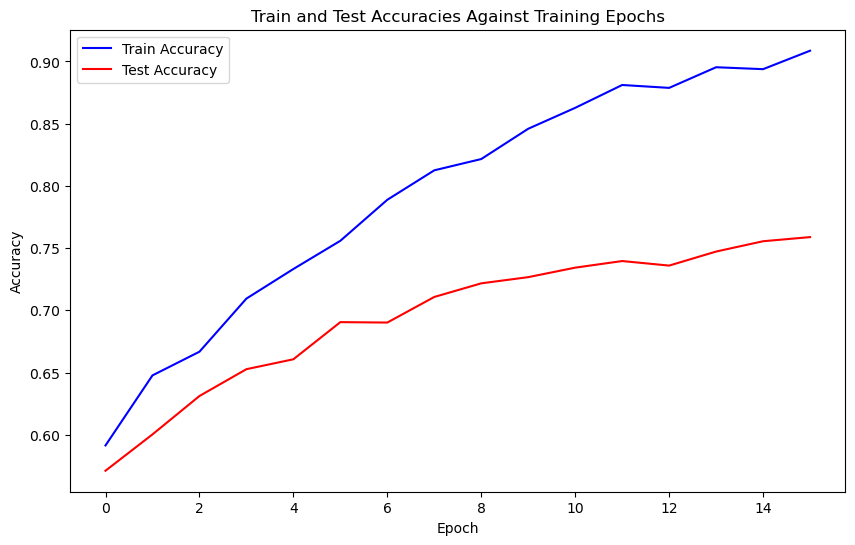

In [13]:
# Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(test_accuracies, label='Test Accuracy', color='red')
plt.title('Train and Test Accuracies Against Training Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

7.As you've astutely observed, we're facing a significant challenge in enumerating all possible combinations of widths and depths and searching over them. Given the circumstances, could you explore and implement a more efficient method for searching through these combinations that could significantly reduce the computational time but achieve similar search results?